In [1]:
# Importing required libraries.
import pandas as pd
import numpy as np
import seaborn as sns             #visualisation
import matplotlib.pyplot as plt   #visualisation
import os

%matplotlib inline 
sns.set(color_codes=True)

from dotenv import load_dotenv
from core_ds4a_project import cleaning, columns as project_columns, datasets

%load_ext autoreload
%autoreload 1
%aimport core_ds4a_project, core_ds4a_project.cleaning, core_ds4a_project.columns, core_ds4a_project.datasets

pd.set_option("display.max_columns", None)

In [2]:
import folium
import pingouin as pg
from folium.plugins import HeatMap

In [3]:
import statsmodels.formula.api as sm

Environment variables:

In [4]:
load_dotenv('envvars')

ROOT_DATA_PATH = os.environ.get('ROOT_DATA_PATH')
RAW_DATA_PATH = os.environ.get('RAW_DATA_PATH') or f'{ROOT_DATA_PATH}/raw'

Reading data:

In [5]:
(cartera_df, clientes_df, colocacion_df) = datasets.read_joining_datasets(dir_path=RAW_DATA_PATH)

Sorting CARTERA:

In [6]:
cartera_df = cartera_df.sort_values(['FECHA_CIERRE', 'OBLIGACION'], ascending=True)
ind_first = ~(cartera_df.duplicated(keep='first', subset='OBLIGACION'))
ind_last = ~(cartera_df.duplicated(keep='last', subset='OBLIGACION'))

<H2>Data for Modeling:</H2>

Lasts records by client:

In [7]:
lasts_records_cartera_df = cartera_df[ind_last].copy()
lasts_records_cartera_df.shape

(38641, 32)

In [8]:
lasts_records_cartera_df.head(5)

,OBLIGACION,CLIENTE,TIPO_CLIENTE_COD,TIPO_CLIENTE,REGION,MUNICIPIO_CLIENTE,VALOR_CUOTA,CUOTAS_PACTADAS,CUOTAS_PENDIENTES,TASA_PERIODICA,PERIODICIDAD_PAGO,CALIFICACION_CIERRE,MODALIDAD,SALDO,VENCIDA,DIAS_VENCIDO,CAPITAL_VEN,INTERES_VEN,MORA,SEGURO_VIDA,COMISION,OTROS,FECHA_ULT_PAGO,FECHA_PROXIMO_PAGO,FECHA_VENCIMIENTO_FINAL,PORCENTAJE_PAGO,TIPO_CREDITO,SUCURSAL_COD,FECHA_CIERRE,SUCURSAL_REAL,MUNICIPIO_LAT,MUNICIPIO_LON
210924,171000008,FA12448,1.0,Microfinanciero,REGION SUR,SABANALARGA,197638,12,12,2.64,Mensual,A,CREDITO RURAL INDIVIDUAL - GERMINA,2000000,-,0,-,-,-,-,0,0,2017-01-20,2017-02-19,2018-01-19,100.0,NUEVO,NaN,2017-01-31,MONTERREY,4.85430,-73.04003
210739,172000006,FA25175,1.0,Microfinanciero,REGION VILLAVICENCIO,VILLAVICENCIO,293974,36,36,2.94,Mensual,A,DESARROLLO EMPRESARIAL CRECER (PYME),6000000,-,0,-,-,-,-,0,0,NaT,2017-02-19,2020-01-19,100.0,RETANQUEADO,NaN,2017-01-31,VILLAVICENCIO,4.14200,-73.62664
210815,173000013,FA23399,1.0,Microfinanciero,REGION META,ACACIAS,183032,24,24,2.94,Mensual,A,DESARROLLO EMPRESARIAL CRECER (PYME),2950000,-,0,-,-,-,-,0,0,NaT,2017-02-27,2019-01-27,100.0,NUEVO,NaN,2017-01-31,ACACIAS,3.98695,-73.75797
210887,176000015,FA19928,1.0,Microfinanciero,REGION META,GRANADA,179930,24,24,2.94,Mensual,A,DESARROLLO EMPRESARIAL CRECER (PYME),2900000,-,0,-,-,-,-,0,0,NaT,2017-02-28,2019-01-31,100.0,NUEVO,NaN,2017-01-31,GRANADA,3.54625,-73.70687
210843,177000008,FA227,1.0,Microfinanciero,REGION SUR,MONTERREY,103305,12,12,2.94,Mensual,A,DESARROLLO EMPRESARIAL CRECER (PYME),1000000,-,0,-,-,-,-,0,0,NaT,2017-02-28,2018-01-31,100.0,NUEVO,NaN,2017-01-31,MONTERREY,4.87802,-72.89575


Creditos y Clientes con calificacion 'A'

In [9]:
idx = lasts_records_cartera_df['CALIFICACION_CIERRE'] == 'A'
len(lasts_records_cartera_df[idx]), len(lasts_records_cartera_df[idx]['CLIENTE'].unique())

(33021, 19070)

Creditos y Clientes con calificacion diferente de 'A'

In [10]:
idx = lasts_records_cartera_df['CALIFICACION_CIERRE'] != 'A'
len(lasts_records_cartera_df[idx]), len(lasts_records_cartera_df[idx]['CLIENTE'].unique())

(5620, 5487)

In [11]:
model1_df = pd.merge(lasts_records_cartera_df, colocacion_df, how='left', on="OBLIGACION", suffixes=('_left', '_right'))
model1_df.shape

(38641, 57)

In [12]:
model1_df = model1_df.rename(columns={'CLIENTE_left':'CLIENTE',
                                      'VALOR_CUOTA_left':'VALOR_CUOTA'
                                     })

In [13]:
model_df = pd.merge(model1_df, clientes_df, how='left', on="CLIENTE", suffixes=('_left_model', '_right_client'))
model_df.shape

(38641, 83)

In [14]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38641 entries, 0 to 38640
Data columns (total 83 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   OBLIGACION               38641 non-null  int32         
 1   CLIENTE                  38641 non-null  object        
 2   TIPO_CLIENTE_COD         38641 non-null  float64       
 3   TIPO_CLIENTE             38641 non-null  object        
 4   REGION                   38641 non-null  object        
 5   MUNICIPIO_CLIENTE        38641 non-null  object        
 6   VALOR_CUOTA              38641 non-null  object        
 7   CUOTAS_PACTADAS          38641 non-null  int32         
 8   CUOTAS_PENDIENTES        38641 non-null  int32         
 9   TASA_PERIODICA           38641 non-null  float64       
 10  PERIODICIDAD_PAGO_left   38641 non-null  category      
 11  CALIFICACION_CIERRE      38641 non-null  object        
 12  MODALIDAD_left           38641 n

In [15]:
null_eda = model_df.isnull().sum().to_frame(name='Nulos').reset_index()
null_eda[null_eda['Nulos'] > 0]

,index,Nulos
22,FECHA_ULT_PAGO,3034
27,SUCURSAL_COD,8
29,SUCURSAL_REAL,12
30,MUNICIPIO_LAT,88
31,MUNICIPIO_LON,88
43,OBSERVACIONES,644
53,CREDITOS_VIGENTES,19887
56,DEFAULT,37678
58,ESTRATO,54
59,SUCURSAL,1


<H2>Feature Engineer</H2>

In [16]:
model_df['DEFAULT'].unique()

array([nan, True], dtype=object)

In [17]:
idx = model_df["DEFAULT"] != True
model_df.loc[idx,'DEFAULT'] = 0

In [18]:
idx = model_df["DEFAULT"] == True
model_df.loc[idx,'DEFAULT'] = 1

In [19]:
model_df['DEFAULT'] = model_df['DEFAULT'].astype('int64')

In [20]:
model_df['DEFAULT'].unique()

array([0, 1], dtype=int64)

- Mes(n-3) Credit 1 Q=A
- Mes(n-2) Credit 1 Q=A
- Mes(n-1) Credit 1 Q=B  ---- ultimo  -> DEFAULT_Q = 1

- Mes(n-1) Credito 2 Q=A ---- ultimo  -> DEFAULT_Q = 0

model_df['DEFAULT_Q'] = 0
nok = model_df["CALIFICACION_CIERRE"] != "A"
model_df.loc[nok,'DEFAULT_Q'] = 1

model_df.loc[nok,'DEFAULT_Q']

In [21]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38641 entries, 0 to 38640
Data columns (total 83 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   OBLIGACION               38641 non-null  int32         
 1   CLIENTE                  38641 non-null  object        
 2   TIPO_CLIENTE_COD         38641 non-null  float64       
 3   TIPO_CLIENTE             38641 non-null  object        
 4   REGION                   38641 non-null  object        
 5   MUNICIPIO_CLIENTE        38641 non-null  object        
 6   VALOR_CUOTA              38641 non-null  object        
 7   CUOTAS_PACTADAS          38641 non-null  int32         
 8   CUOTAS_PENDIENTES        38641 non-null  int32         
 9   TASA_PERIODICA           38641 non-null  float64       
 10  PERIODICIDAD_PAGO_left   38641 non-null  category      
 11  CALIFICACION_CIERRE      38641 non-null  object        
 12  MODALIDAD_left           38641 n

In [22]:
null_eda = model_df.isnull().sum().to_frame(name='Nulos').reset_index()
null_eda[null_eda['Nulos'] > 0]

,index,Nulos
22,FECHA_ULT_PAGO,3034
27,SUCURSAL_COD,8
29,SUCURSAL_REAL,12
30,MUNICIPIO_LAT,88
31,MUNICIPIO_LON,88
43,OBSERVACIONES,644
53,CREDITOS_VIGENTES,19887
58,ESTRATO,54
59,SUCURSAL,1
62,ACTIVIDAD_ECONOMICA,251


len(model_df.loc[model_df['DEFAULT_Q'] == 1])

len(model_df.loc[model_df['DEFAULT_Q'] == 0])

In [23]:
len(model_df.loc[model_df['DEFAULT'] == 1])

963

In [24]:
len(model_df.loc[model_df['DEFAULT'] == 0])

37678

Looking at correlations:

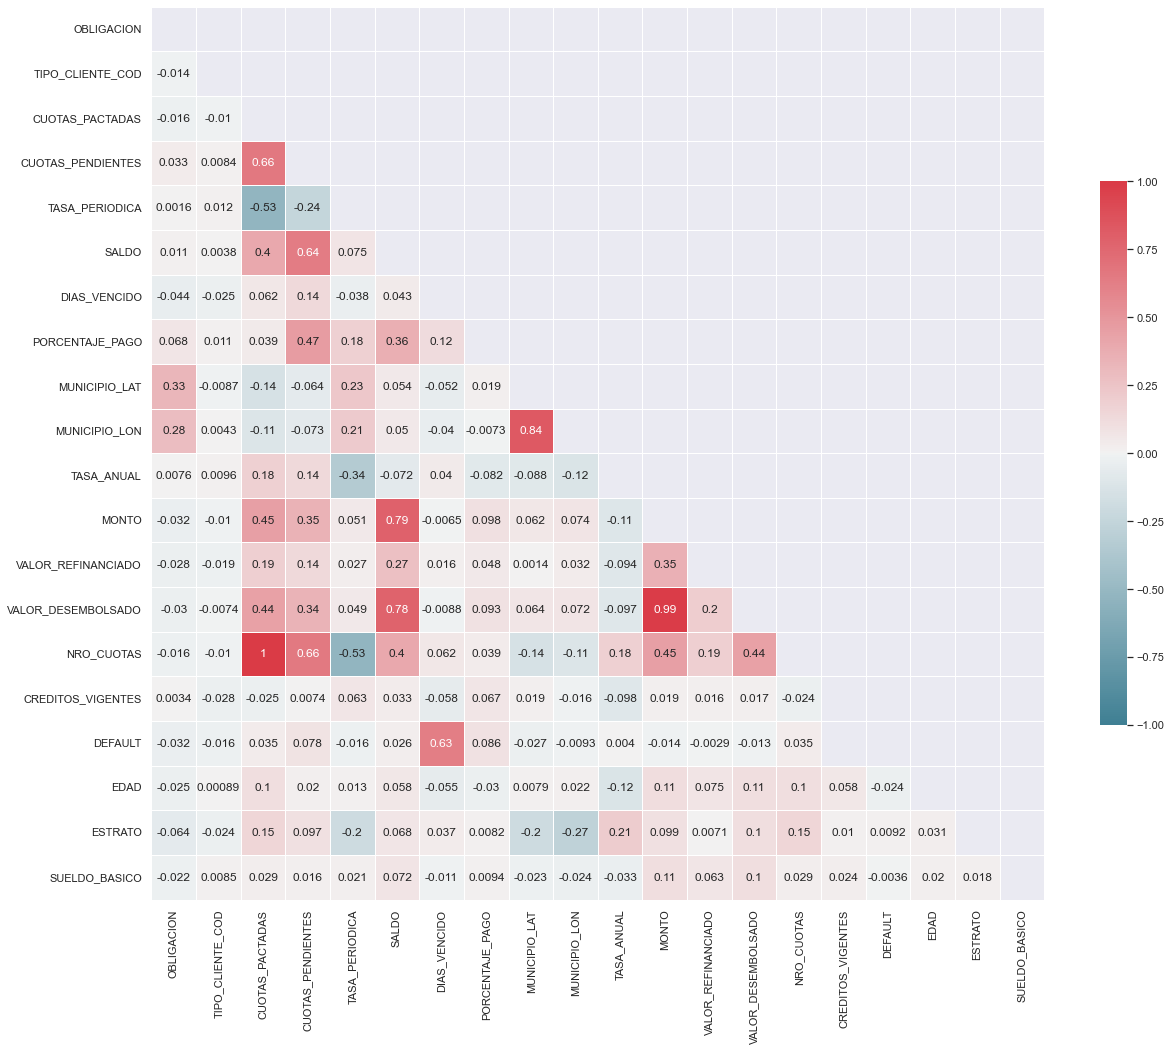

In [25]:
#compute correlation matrix
df_correlations = model_df.corr()

#mask the upper half for visualization purposes
mask = np.zeros_like(df_correlations, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

# Draw the heatmap with the mask and correct aspect ratio
plt.figure(figsize= (20,20))

cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df_correlations,
            mask=mask,  
            vmax=1, 
            vmin=-1, 
            cmap=cmap, 
            center=0,
            annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

Split our data into training and testing sets (an 80-20 split is a good starting point):

In [26]:
np.random.seed(1234) # a seed makes the analysis reproducible
                     # so everyone will get the same results

n_data = len(model_df)

# Randomly choose 0.8n indices between 1 and n
idx_train = np.random.choice(range(n_data), int(0.8*n_data), replace=False)

# The test set is comprised from all the indices that were
# not selected in the training set:
idx_test  = np.asarray(list(set(range(n_data)) - set(idx_train)))

df_train     = model_df.iloc[idx_train] # the training data set
df_test      = model_df.iloc[idx_test]  # the test data set

print(df_train.shape) 
print(df_test.shape)  

(30912, 83)
(7729, 83)


len(df_train.loc[df_train['DEFAULT_Q'] == 1])

len(df_test.loc[df_test['DEFAULT_Q'] == 1])

In [27]:
len(df_train.loc[df_train['DEFAULT'] == 1])

780

In [28]:
len(df_train.loc[df_train['DEFAULT'] == 0])

30132

In [29]:
df_train.shape

(30912, 83)

In [30]:
df_train.dropna().shape

(3382, 83)

<H2> MODEL 1: Multiple linear regression </H2>

Regression model for estimating the amount's loan as a function of some variables like age, education level, etc. 

First we are going to analize 

In [38]:
df_train['SUELDO_BASICO'].value_counts(dropna=False)

0.0           27807
3000000.0       167
2000000.0       161
2500000.0       118
1800000.0       115
              ...  
737000.0          1
2653000.0         1
10500000.0        1
2601600.0         1
6932000.0         1
Name: SUELDO_BASICO, Length: 578, dtype: int64

In [44]:
formula_lin = 'np.log(MONTO) ~  C(ESTADO_CIVIL_COD) + '\
                       + 'C(TIPO_VIVIENDA) + C(MUNICIPIO_CLIENTE) + '\
                       + 'C(TIPO_UBICACION_COD)  + C(RESPONSABLE_DE_HOGAR) +  '\
                       + 'C(GENERO_COD) + C(ESTRATO) + SUELDO_BASICO + EDAD + C(NIVEL_ESTUDIOS_COD)'
#                       + 'C(CUOTAS_PENDIENTES) + VALOR_DESEMBOLSADO + PORCENTAJE_PAGO + C(OCUPACION) +'\
#                       + 'VALOR_REFINANCIADO + C(NRO_CUOTAS) + C(MUJER_CABEZA) '\
model_lin = sm.ols(formula = formula_lin, data = df_train.query('SUELDO_BASICO > 0 & CALIFICACION_CIERRE=="A"')).fit()
print(model_lin.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(MONTO)   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     6.831
Date:                Tue, 05 Jul 2022   Prob (F-statistic):           4.35e-65
Time:                        20:36:36   Log-Likelihood:                -2891.2
No. Observations:                2621   AIC:                             5952.
Df Residuals:                    2536   BIC:                             6451.
Df Model:                          84                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

## ESTE ES

In [47]:
formula_lin = 'np.log(MONTO) ~  C(ESTADO_CIVIL_COD) + '\
                       + 'C(TIPO_VIVIENDA) + C(MUNICIPIO_CLIENTE) + '\
                       + 'C(TIPO_UBICACION_COD)  + C(RESPONSABLE_DE_HOGAR) +  '\
                       + 'C(GENERO_COD) + C(ESTRATO) + np.log(SUELDO_BASICO) + EDAD + C(NIVEL_ESTUDIOS_COD)'
#                       + 'C(CUOTAS_PENDIENTES) + VALOR_DESEMBOLSADO + PORCENTAJE_PAGO + C(OCUPACION) +'\
#                       + 'VALOR_REFINANCIADO + C(NRO_CUOTAS) + C(MUJER_CABEZA) '\
model_lin = sm.ols(formula = formula_lin, data = df_train.query('SUELDO_BASICO > 0 & CALIFICACION_CIERRE=="A"')).fit()
print(model_lin.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(MONTO)   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     7.664
Date:                Tue, 05 Jul 2022   Prob (F-statistic):           1.09e-75
Time:                        20:42:50   Log-Likelihood:                -2862.0
No. Observations:                2621   AIC:                             5894.
Df Residuals:                    2536   BIC:                             6393.
Df Model:                          84                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

In [41]:
formula_lin = 'np.log(MONTO) ~  C(ESTADO_CIVIL_COD) + '\
                       + 'C(TIPO_VIVIENDA) + C(MUNICIPIO_CLIENTE) + '\
                       + 'C(TIPO_UBICACION_COD)  + C(RESPONSABLE_DE_HOGAR) +  '\
                       + 'C(GENERO_COD) + C(ESTRATO) + SUELDO_BASICO + C(EDAD) + C(NIVEL_ESTUDIOS_COD)'
#                       + 'C(CUOTAS_PENDIENTES) + VALOR_DESEMBOLSADO + PORCENTAJE_PAGO + C(OCUPACION) +'\
#                       + 'VALOR_REFINANCIADO + C(NRO_CUOTAS) + C(MUJER_CABEZA) '\
model_lin = sm.ols(formula = formula_lin, data = df_train.query('SUELDO_BASICO > 0')).fit()
print(model_lin.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(MONTO)   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     5.037
Date:                Tue, 05 Jul 2022   Prob (F-statistic):           7.58e-66
Time:                        20:30:01   Log-Likelihood:                -3251.6
No. Observations:                2995   AIC:                             6785.
Df Residuals:                    2854   BIC:                             7632.
Df Model:                         140                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

In [31]:
formula_lin = 'np.log(MONTO) ~  C(ESTADO_CIVIL_COD) + '\
                       + 'C(TIPO_VIVIENDA) + C(MUNICIPIO_CLIENTE) + '\
                       + 'C(TIPO_UBICACION_COD)  + C(RESPONSABLE_DE_HOGAR) +  '\
                       + 'C(GENERO_COD) + C(ESTRATO) + SUELDO_BASICO + EDAD + C(NIVEL_ESTUDIOS_COD)'
#                       + 'C(CUOTAS_PENDIENTES) + VALOR_DESEMBOLSADO + PORCENTAJE_PAGO + C(OCUPACION) +'\
#                       + 'VALOR_REFINANCIADO + C(NRO_CUOTAS) + C(MUJER_CABEZA) '\
model_lin = sm.ols(formula = formula_lin, data = df_train).fit()
print(model_lin.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(MONTO)   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     33.83
Date:                Tue, 05 Jul 2022   Prob (F-statistic):               0.00
Time:                        20:23:10   Log-Likelihood:                -32046.
No. Observations:               29267   AIC:                         6.429e+04
Df Residuals:                   29166   BIC:                         6.513e+04
Df Model:                         100                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------

In [48]:
formula_lin1 = 'DEFAULT ~  SALDO + C(ESTADO_CIVIL_COD) + '\
                       + 'C(TIPO_VIVIENDA) + C(MUNICIPIO_CLIENTE) + C(CALIFICACION_CIERRE) + '\
                       + 'C(CUOTAS_PENDIENTES) + VALOR_DESEMBOLSADO + PORCENTAJE_PAGO + '\
                       + 'VALOR_REFINANCIADO + C(NRO_CUOTAS) + '\
                       + 'C(TIPO_UBICACION_COD) + C(MUJER_CABEZA) + C(RESPONSABLE_DE_HOGAR) + C(OCUPACION) + '\
                       + 'C(GENERO_COD) + C(ESTRATO) + SUELDO_BASICO + EDAD + TASA_PERIODICA + C(NIVEL_ESTUDIOS_COD)'
model_lin1 = sm.ols(formula = formula_lin1, data = df_train).fit()
print(model_lin1.summary())

                            OLS Regression Results                            
Dep. Variable:                DEFAULT   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     37.30
Date:                Tue, 05 Jul 2022   Prob (F-statistic):               0.00
Time:                        20:45:09   Log-Likelihood:                 16432.
No. Observations:               29152   AIC:                        -3.237e+04
Df Residuals:                   28903   BIC:                        -3.031e+04
Df Model:                         248                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------

In [49]:
formula_lin1 = 'DEFAULT ~  C(ESTADO_CIVIL_COD) + '\
                       + 'C(TIPO_VIVIENDA) + C(MUNICIPIO_CLIENTE) + '\
                       + 'VALOR_DESEMBOLSADO + C(NRO_CUOTAS) + '\
                       + 'C(TIPO_UBICACION_COD) + C(MUJER_CABEZA) + C(RESPONSABLE_DE_HOGAR) + C(OCUPACION) + '\
                       + 'C(GENERO_COD) + C(ESTRATO) + np.log(SUELDO_BASICO) + EDAD + TASA_ANUAL + C(NIVEL_ESTUDIOS_COD)'
model_lin1 = sm.ols(formula = formula_lin1, data = df_train.query('SUELDO_BASICO > 0')).fit()
print(model_lin1.summary())

                            OLS Regression Results                            
Dep. Variable:                DEFAULT   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     1.400
Date:                Tue, 05 Jul 2022   Prob (F-statistic):            0.00176
Time:                        20:48:40   Log-Likelihood:                 1700.6
No. Observations:                2985   AIC:                            -3121.
Df Residuals:                    2845   BIC:                            -2281.
Df Model:                         139                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

In [43]:

formula_lin1 = 'DEFAULT ~  SALDO + C(ESTADO_CIVIL_COD) + '\
                       + 'C(TIPO_VIVIENDA) + C(MUNICIPIO_CLIENTE) + C(CALIFICACION_CIERRE) + '\
                       + 'C(CUOTAS_PENDIENTES) + VALOR_DESEMBOLSADO + PORCENTAJE_PAGO + '\
                       + 'VALOR_REFINANCIADO + C(NRO_CUOTAS) + '\
                       + 'C(TIPO_UBICACION_COD) + C(MUJER_CABEZA) + C(RESPONSABLE_DE_HOGAR) + C(OCUPACION) + '\
                       + 'C(GENERO_COD) + C(ESTRATO) + SUELDO_BASICO + EDAD + TASA_PERIODICA + C(NIVEL_ESTUDIOS_COD)'
model_lin1 = sm.ols(formula = formula_lin1, data = df_train.query('SUELDO_BASICO > 0')).fit()
print(model_lin1.summary())

                            OLS Regression Results                            
Dep. Variable:                DEFAULT   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     6.272
Date:                Tue, 05 Jul 2022   Prob (F-statistic):          1.68e-114
Time:                        20:33:05   Log-Likelihood:                 2132.0
No. Observations:                2985   AIC:                            -3882.
Df Residuals:                    2794   BIC:                            -2736.
Df Model:                         190                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

In [33]:
model_lin1.rsquared

0.24245617372833272

In [34]:
model_lin1.aic

-32366.955692661875

Variables from our model are statistically significant:

In [35]:
alpha = 0.05                  # level of significance / type-I error rate
m = len(model_lin1.pvalues)    # number of tests
significant = np.sum(model_lin.pvalues  < alpha)
significant, m

(51, 253)

In [36]:
model_lin1.params

Intercept                  -3.899901e-02
C(ESTADO_CIVIL_COD)[T.D]    8.862473e-04
C(ESTADO_CIVIL_COD)[T.O]    6.420597e-02
C(ESTADO_CIVIL_COD)[T.S]    1.486882e-03
C(ESTADO_CIVIL_COD)[T.U]   -1.362478e-03
                                ...     
PORCENTAJE_PAGO             9.110420e-05
VALOR_REFINANCIADO         -3.691161e-09
SUELDO_BASICO               3.049952e-10
EDAD                        7.761937e-05
TASA_PERIODICA              2.370723e-03
Length: 253, dtype: float64

In [37]:
model_lin1.pvalues

Intercept                   0.842956
C(ESTADO_CIVIL_COD)[T.D]    0.845744
C(ESTADO_CIVIL_COD)[T.O]    0.083676
C(ESTADO_CIVIL_COD)[T.S]    0.546829
C(ESTADO_CIVIL_COD)[T.U]    0.530550
                              ...   
PORCENTAJE_PAGO             0.020935
VALOR_REFINANCIADO          0.007743
SUELDO_BASICO               0.584340
EDAD                        0.328097
TASA_PERIODICA              0.000387
Length: 253, dtype: float64